# Imports & Load Data 🏜️

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
import cv2
import matplotlib.pyplot as plt
import random
from typing import List, Tuple

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

### Load Dataset

In [ ]:
from google.colab import userdata

os.environ['WANDB_DISABLED'] = 'true'
roboflow_api = userdata.get('ROBOFLOW')

In [ ]:
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api)
project = rf.workspace("potholedetection-86cjl").project("pothole_segmentation")
version = project.version(8)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to pothole_segmentation-8 in yolov8:: 100%|██████████| 6160/6160 [00:01<00:00, 4071.94it/s]


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDatasetYOLOv8(Dataset):

  @staticmethod
  def load_mask_vertices(mask_path: str, img_height:int, img_width: int)->List[dict]:
      with open(mask_path, 'r') as file:
        lines = file.readlines()
      polygon_labels = []
      for line in lines:
        values = line.strip().split(' ')
        class_label = int(values[0])
        polygon_coords = [(int(float(values[i]) * img_width), int(float(values[i + 1]) * img_height)) for i in range(1, len(values), 2)]
        polygon_labels.append({'class_label': 1, 'polygon_coords': polygon_coords})

      return polygon_labels

  @staticmethod
  def generate_mask_from_vertices(vertices: List[dict], img_height:int, img_width: int)->np.ndarray:
      binary_mask = np.zeros((img_height,img_width), dtype=np.uint8)
      for polygon in vertices :
        polygon_coords = np.array(polygon['polygon_coords'],np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(binary_mask,[polygon_coords],color=(1))
      return binary_mask

  @staticmethod
  def generate_labels_dataframe(data_dir)->pd.DataFrame:
    img_dir = os.path.join(data_dir, 'images')
    mask_dir = os.path.join(data_dir, 'labels')
    img_names, mask_names = [], []
    hits, misses = 0, 0
    for root, dir, files in os.walk(img_dir):
        for img_name in files:
            try:
              mask_name = '.'.join(img_name.split('.')[:-1])+'.txt'
              if os.path.exists(os.path.join(mask_dir, mask_name)):
                  img_names.append(os.path.join(img_dir, img_name))
                  mask_names.append(os.path.join(mask_dir, mask_name))
                  hits += 1
              else:
                  misses += 1
            except:
              misses += 1
    print(f"\033[92m Found {hits} records with {misses} errors \033[0m")
    df = pd.DataFrame(data = {'image': img_names, 'mask': mask_names}, columns=['image', 'mask'])
    return df

  def __init__(self, data_dir, img_height, img_width, labels: pd.DataFrame = None, transforms = None) -> None:
      super().__init__()
      self.img_dir = os.path.join(data_dir, 'images')
      self.mask_dir = os.path.join(data_dir, 'labels')
      if labels is None:
        self.df = self.generate_labels_dataframe(data_dir)
      else:
        self.df = labels.copy()
        assert type(labels)==pd.DataFrame and labels.iloc[:, 0].dtype == 'O', 'Inconsistent Labels Dataframe Provided'
      self.df.iloc[:, 1] = self.df.iloc[:, 1].apply(lambda x: self.load_mask_vertices(x, img_height, img_width))
      self.transforms = transforms
      self.img_height = img_height
      self.img_width = img_width

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        mask_vertices = self.df.iloc[idx, 1]
        #Albumentations only accepts Numpy arrays
        image = cv2.imread(img_path)
        mask = self.generate_mask_from_vertices(mask_vertices, self.img_height, self.img_width)
        mask = mask.astype(np.float32)
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        return image, mask

  def load_mask(self, mask_path: str, img_height:int, img_width: int)->np.ndarray:
    vertices = self.load_mask_vertices(mask_path, img_height, img_width)
    mask = self.generate_mask_from_vertices(vertices, img_height, img_width)
    return mask

In [ ]:
TRAIN_DATA = r"/content/pothole_segmentation-8/train"
VAL_DATA = r"/content/pothole_segmentation-8/valid"
TEST_DATA = r"/content/pothole_segmentation-8/test"

In [ ]:
ValDataset = SegmentationDatasetYOLOv8(VAL_DATA, 640, 640)
img, mask = ValDataset[0]
print(f"Images: {img.shape} , Masks: {mask.shape}")

 Found 317 records with 0 errors 
Images: (640, 640, 3) , Masks: (640, 640)


### Visualize Dataset

 Found 317 records with 0 errors 


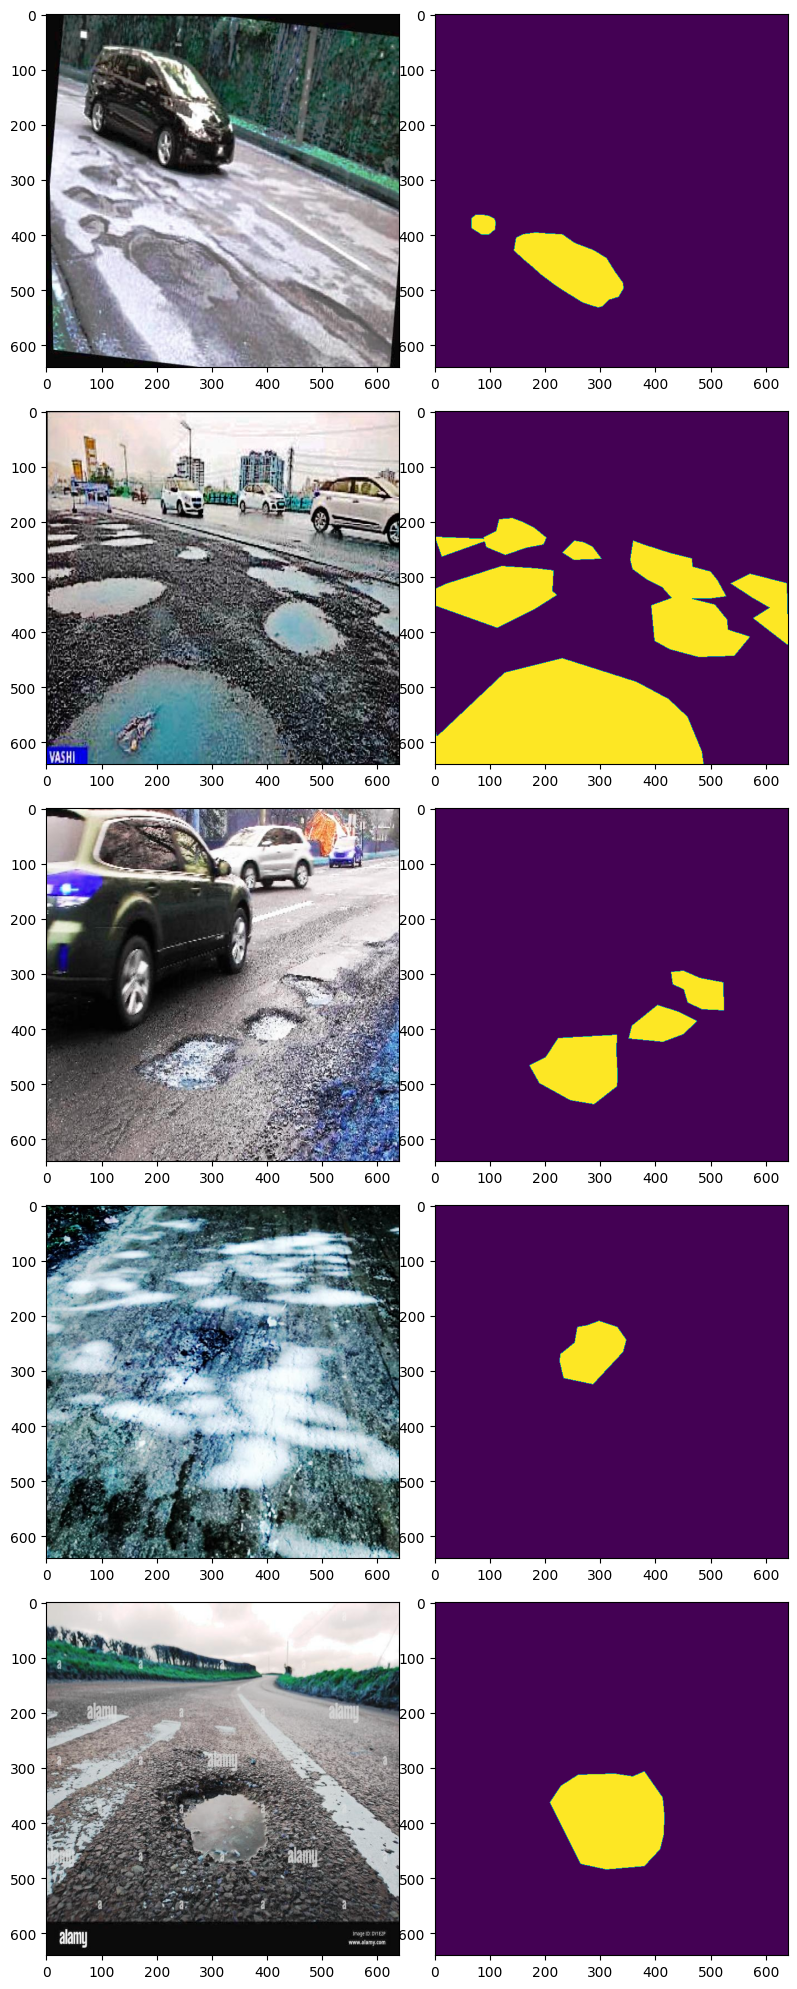

In [ ]:
def visualize_data(data: torch.utils.data.Dataset, m: int = 5)->None:
  n = len(data)
  fig, ax = plt.subplots(nrows=m, ncols=2, figsize=(8, 4*m))
  for i in range(m):
    idx = random.randint(0, n-1)
    img, mask = data[idx]
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(np.squeeze(mask, axis=0))
  plt.tight_layout()
  plt.show()

ValDataset = SegmentationDatasetYOLOv8(VAL_DATA, 640, 640)
visualize_data(ValDataset)

### Albumentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
transforms_dict = {
    "GridDistortion": A.GridDistortion(p=1.0),
    "OpticalDistortion": A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1.0),
    "CLAHE": A.CLAHE(p=1.0),
    "ShiftScaleRotate": A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=1.0),
    "RGBShift": A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=1.0),
    "RandomBrightnessContrast": A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),
    "HorizontalFlip": A.HorizontalFlip(p=1.0),
    "VerticalFlip": A.VerticalFlip(p=1.0),
    "RandomGamma": A.RandomGamma(p=1.0),
}

In [ ]:
transforms = [
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.RandomGamma(p=0.8),
]

train_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2(),
    ]
)

In [ ]:
def visualize_segmentation_transforms(img, mask, transforms):
    n = len(transforms)+1
    fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 5*n))

    mask = np.squeeze(mask, axis=0)
    ax[0][0].imshow(img)
    ax[0][1].imshow(mask)
    for i, (transform_name, transform) in enumerate(transforms_dict.items()):
        augObj = transform(image=img, mask=mask)
        aug_img = augObj['image']
        aug_mask = augObj['mask']
        ax[i+1][0].imshow(aug_img)
        ax[i+1][1].imshow(aug_mask)
        ax[i+1][0].set_title(transform_name)
    plt.tight_layout()
    plt.show()

visualize_segmentation_transforms(ValDataset[2][0], ValDataset[2][1], transforms)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
transforms = [
    A.OneOf([
    A.GridDistortion(p=0.3),
    A.OpticalDistortion(distort_limit=1.5, shift_limit=0.5, p=0.1),
    ], p=0.8),
    A.CLAHE(p=0.8),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
    A.RandomBrightnessContrast(p=0.8),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.1),
    A.RandomGamma(p=0.8),
]

train_transforms = A.Compose([A.Resize(256, 256),]+transforms+[A.Normalize(), ToTensorV2(),])
val_transforms = A.Compose([A.Resize(256, 256), A.Normalize(), ToTensorV2(),])

Train_Dataset = SegmentationDatasetYOLOv8(TRAIN_DATA, 640, 640, transforms=train_transforms)
Val_Dataset = SegmentationDatasetYOLOv8(VAL_DATA, 640, 640, transforms=val_transforms)

 Found 2443 records with 0 errors 
 Found 317 records with 0 errors 


In [ ]:
Train_Dataset[0][0].shape, Train_Dataset[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

# Train Model 🚀

In [ ]:
!pip install -q -U ternausnet

In [ ]:
BATCH_SIZE = 16
NUM_WORKERS = 2
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_loader = DataLoader(
    Train_Dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
val_loader = DataLoader(
    Val_Dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [ ]:
import ternausnet.models

model = getattr(ternausnet.models, "UNet11")(pretrained=True)
model = model.to(DEVICE)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.


In [ ]:
criterion = torch.nn.BCEWithLogitsLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class Logger:
  def __init__(self, train_loader) -> None:
     self.history = {
         'train_loss': [],
         'val_loss': [],
     }
     self.epochs = 0
     self.steps = 0
     self.interval = len(train_loader)//20
     self.best_loss = np.inf

  def start_epoch(self):
    self.steps = 0
    self.epochs += 1
    print(f"Epoch {self.epochs}  \033[35m", end='')

  def end_epoch(self):
    print(f"\033[0m  TrainLoss: {self.history['train_loss'][-1]}  ValLoss: {self.history['val_loss'][-1]}")

  def update_history(self, split, loss):
    self.history[f'{split}_loss'].append(loss)

  def step(self):
    self.steps += 1
    if self.steps % self.interval == 0:
      print("|", end='')

In [ ]:
logr = Logger(train_loader)
model.to(DEVICE)
for epochs in range(EPOCHS):
    logr.start_epoch()
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        logr.step()
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        assert (outputs.shape==targets.shape), f"Shapes of output {outputs.shape} and target {targets.shape} do not match for input {inputs.shape}"
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    logr.update_history('train', running_loss/len(train_loader))

    running_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
        logr.update_history('val', running_loss/len(val_loader))

    logr.end_epoch()

Epoch 1  |||||||||||||||||||||  TrainLoss: 0.4243197717697792  ValLoss: 0.3709410890936852
Epoch 2  |||||||||||||||||||||  TrainLoss: 0.3678317566712697  ValLoss: 0.2913802616298199
Epoch 3  |||||||||||||||||||||  TrainLoss: 0.3431629327192805  ValLoss: 0.28698904514312745
Epoch 4  |||||||||||||||||||||  TrainLoss: 0.32803117771164264  ValLoss: 0.28005987256765363
Epoch 5  |||||||||||||||||||||  TrainLoss: 0.3171726373675602  ValLoss: 0.26999037712812424
Epoch 6  |||||||||||||||||||||  TrainLoss: 0.3073109873369628  ValLoss: 0.26836795061826707
Epoch 7  |||||||||||||||||||||  TrainLoss: 0.3020384187012716  ValLoss: 0.2630738377571106
Epoch 8  |||||||||||||||||||||  TrainLoss: 0.2984242236692142  ValLoss: 0.2553625263273716
Epoch 9  |||||||||||||||||||||  TrainLoss: 0.2848234622696646  ValLoss: 0.31070890203118323
Epoch 10  |||||||||||||||||||||  TrainLoss: 0.28514692576882106  ValLoss: 0.2464936427772045


# Inference & Benchmarking 🔍

### Inference Pipeline

In [ ]:
model.eval()

def inference_pipeline(img: torch.Tensor|np.ndarray, threshold = 0)->np.ndarray:
  if type(img) == np.ndarray:
    img = val_transforms(image=img)['image']
  with torch.no_grad():
      input = torch.unsqueeze(img, 0).to(DEVICE)
      output = model(input)
      output = torch.squeeze(output, [0, 1]).cpu().numpy()
      output = (output > threshold).astype(int)
      return output

In [ ]:
Test_Dataset = SegmentationDatasetYOLOv8(TEST_DATA, 640, 640, transforms=None)

 Found 314 records with 0 errors 


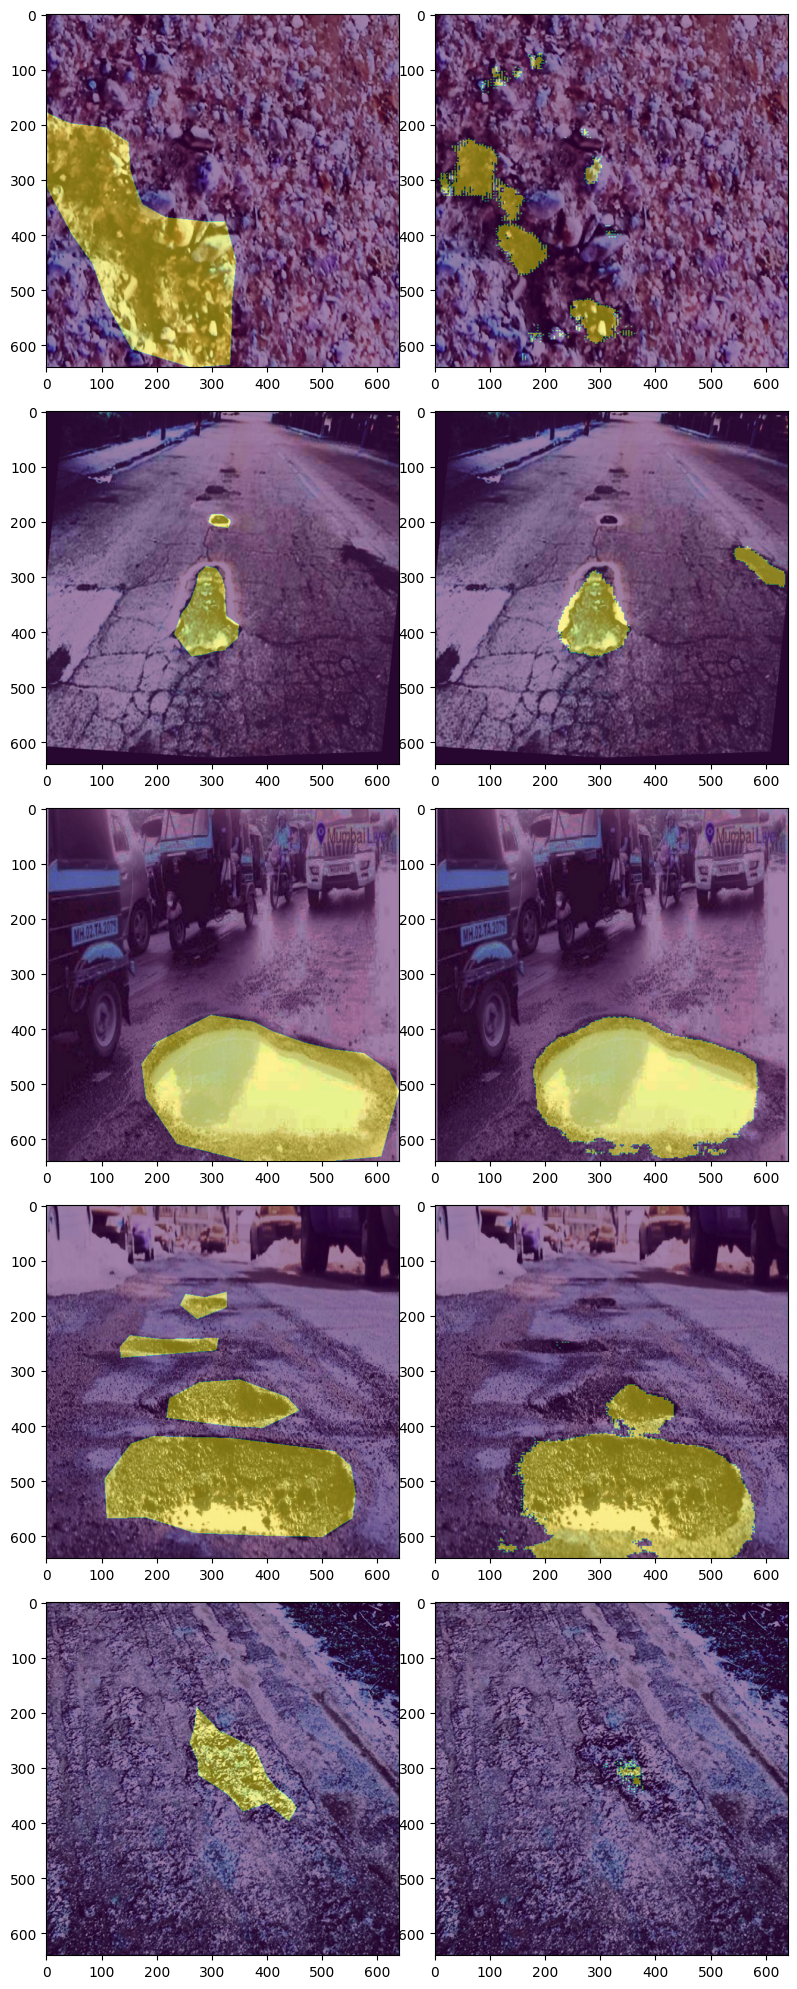

In [ ]:
def visualize_data(data: torch.utils.data.Dataset, m: int = 5)->None:
  n = len(data)
  fig, ax = plt.subplots(nrows=m, ncols=2, figsize=(8, 4*m))
  for i in range(m):
    idx = random.randint(0, n-1)
    img, mask = data[idx]
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(img)
    ax[i, 0].imshow(mask, alpha=0.5)
    pred = inference_pipeline(img)
    pred = cv2.resize(pred, (640, 640), interpolation=cv2.INTER_NEAREST)
    ax[i, 1].imshow(pred, alpha=0.5)
  plt.tight_layout()
  plt.show()

visualize_data(Test_Dataset)

### BenchMarks

In [ ]:
!pip install -q -U torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 22.9 MB/s eta 0:00:00


In [ ]:
from torchmetrics import JaccardIndex, Dice, F1Score

In [ ]:
def evaluate_metrics(test_data):
  metrics = {
      "jaccard": 0.0,
      "dice": 0.0,
      "f1-score": 0.0,
  }
  jaccard = JaccardIndex(num_classes=1, task='binary').to(DEVICE)
  dice = Dice(num_classes=1, multiclass=False).to(DEVICE)
  f1 = F1Score(num_classes=1, task='binary').to(DEVICE)
  with torch.no_grad():
    for img, mask in test_data:
      img, masks = torch.unsqueeze(img, 0).to(DEVICE), mask.to(DEVICE)
      outputs = model(img)
      preds = torch.sigmoid(outputs)
      preds = (preds > 0.5).int()
      mask = mask.int()
      metrics["jaccard"] += jaccard(preds[0][0], mask.to(DEVICE))
      metrics["dice"] += dice(preds[0][0], mask.to(DEVICE))
      metrics["f1-score"] += f1(preds[0][0], mask.to(DEVICE))

  for metric in metrics:
    metrics[metric] /= len(test_data)
  return metrics

In [ ]:
Test_Dataset = SegmentationDatasetYOLOv8(TEST_DATA, 640, 640, transforms=val_transforms)
evaluate_metrics(Test_Dataset)

 Found 314 records with 0 errors 


{'jaccard': tensor(0.4003, device='cuda:0'),
 'dice': tensor(0.5075, device='cuda:0'),
 'f1-score': tensor(0.5075, device='cuda:0')}

### Inference of Real World Data

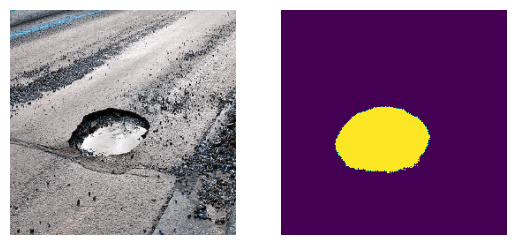

In [ ]:
fig, ax = plt.subplots(1, 2)

img = cv2.imread(r"/content/pothole.jpg")
img = cv2.resize(img, (256, 256))
ax[0].imshow(img)
ax[0].axis('off')

pred = inference_pipeline(img)
ax[1].imshow(pred)
ax[1].axis('off')
plt.show()